# 3945 – Advanced Machine Learning, Sem A 2024
## Home Assignment 2 – Ensemble Learning

In this assignment, you will implement AdaBoost. You will demonstrate the models and design experiments to test their performance.
You should submit a brief report according to the attached template describing your work and finding. The report should be accompanied with a single ipython notebook (.ipynb) file that includes all the code and outputs.
You are encouraged to use methods and techniques covered in class but are also welcome to use any other relevant method you find suitable for the task if you justify your decision. Make sure to use proper ML and DS methodologies when needed (Data preprocessing, Data splits, etc.).

# Submitted

*   Timor Baruch
*   Hadar Pur

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import unittest

import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Part 1: AdaBoost implementation
1. Implement AdaBoost in your notebook.
Note: unless stated otherwise, you should write the code by yourselves. You can use library functions for mathematical calculations when needed.
* Initialize a zero model 𝐻!
* Initialize weights (𝑤" )
* Train a decision stump (h#)
Note: use an existing implementation of weighted decision trees
* Calculate the weighted classification error (𝜖)
* Find the optimal step size (𝛼#)
* Update the model in the boosting step (𝐻#)
* Update the weights (𝑤" )
2. Test your code on simulated data.
Note: this should be a simple “unit test” like dataset that helps you debug and validate the
correctness of your implementation.
3. Compare the results to existing implementations of AdaBoost.


In [2]:
class OurAdaBoost:
    def __init__(self, n_estimators=50, learning_rate=1.0, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.models = []     # List to store weak classifiers (H_i)
        self.alphas = []     # List to store corresponding weights (alpha_i)
        self.scores = []     # List to store scores (if needed)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Initialize weights for AdaBoost
        weights = np.array([1/len(y) for i in range(len(y))])  # Initialize weights (𝑤_i)

        for _ in range(self.n_estimators):
            # Select the first weak classifier (H_0)
            model = select_weak_classifier(X, y, weights, self.random_state)  # Select weak classifier (H_i)

            # Predict using the weak classifier
            predictions = model.predict(X)

            # Compute the error of the weak classifier
            error = compute_error(y, predictions, weights)

            if error < 0.5:  # Ensure that the error is less than 0.5 to prevent division by zero
                # Calculate the weight of the weak classifier (alpha_i)
                alpha = self.learning_rate * 0.5 * np.log((1 - error) / max(error, 1e-10))

                # Update the weights for the next iteration
                weights *= np.exp(-alpha * y * predictions) / (2 * np.sqrt(error * (1 - error)))
                # weights /= np.sum(weights)

                # Store the weak classifier and its weight
                self.models.append(model)    # Store weak classifier (H_i)
                self.alphas.append(alpha)    # Store corresponding weight (alpha_i)
            else:
                break  # Stop if the error is too high

    def predict(self, X):
        # Combine predictions from all weak classifiers
        final_predictions = np.zeros(X.shape[0])
        for model, alpha in zip(self.models, self.alphas):
            predictions = alpha * model.predict(X)
            final_predictions += predictions

        # Apply sign function to get the final prediction
        return np.where(np.sign(final_predictions) == -1, -1, 1)

    def score(self, X, y):
        # Get predictions for the test data
        predictions = self.predict(X)

        # Calculate accuracy
        accuracy = accuracy_score(y, predictions)

        return accuracy

    def get_params(self, deep=True):
        return {'n_estimators': self.n_estimators,
                'learning_rate': self.learning_rate,
                'random_state': self.random_state}


###########################################################

def select_weak_classifier(X, y, weights, random_state):
    # Select weak classifier based on current weights
    model = DecisionTreeClassifier(max_depth=1, random_state=random_state)
    model.fit(X, y, sample_weight=weights)
    return model

def compute_error(y_true, y_pred, weights):
    return np.sum(weights * (y_pred != y_true)) / np.sum(weights)

In [3]:
def plot_dataset(X, y, title):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', s=20)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

def plot_decision_boundaries(ax, X, y, title_pref, clf, feature_names, resolution=0.01):
    # Plot the decision surface
    axis_max = abs(X).max().round() + 1

    xx1, xx2 = np.meshgrid(np.arange(-axis_max, axis_max, resolution),
                           np.arange(-axis_max, axis_max, resolution))
    Z = clf.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)

    ax.contourf(xx1, xx2, Z, alpha=0.4)

    # Plot class sample
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolors='k')

    ax.set_xlim(-axis_max, axis_max)
    ax.set_ylim(-axis_max, axis_max)
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_title(f'Decision Boundaries on {title_pref} set with {clf.__class__.__name__}')


def plot_decision_boundaries_comparison(x_train, y_train, x_test, y_test, adaboost, feature_names):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    for ax, data, label in zip(axs, [(x_train, y_train), (x_test, y_test)], ['Train', 'Test']):
        plot_decision_boundaries(ax, data[0], data[1], label, adaboost, feature_names)
    print(f'Tree: Train accuracy={adaboost.score(x_train, y_train):.2%}, Test accuracy={adaboost.score(x_test, y_test):.2%}')

    plt.show()


def test_fit_predict_custom(x_train, y_train, x_test, y_test):
    # Initialize and fit your custom AdaBoost
    custom_adaboost = OurAdaBoost(n_estimators=50)
    custom_adaboost.fit(x_train, y_train)

    # Make predictions on the test data
    custom_predictions = custom_adaboost.predict(x_test)

    # Calculate and print accuracy
    custom_accuracy = accuracy_score(custom_predictions, y_test)

    print(f"Accuracy of Our AdaBoost: {custom_accuracy:.2%}")
    return custom_adaboost


def test_fit_predict_sklearn(x_train, y_train, x_test, y_test):
    # scikit-learn's AdaBoost
    sklearn_adaboost = AdaBoostClassifier(n_estimators=50)  # Adjust parameters as needed
    sklearn_adaboost.fit(x_train, y_train)

    # Make predictions using scikit-learn's AdaBoost
    sklearn_predictions = sklearn_adaboost.predict(x_test)

    # Calculate and print accuracy
    sklearn_accuracy = accuracy_score(sklearn_predictions, y_test)

    print(f"Accuracy of Scikit-Learn's AdaBoost: {sklearn_accuracy:.2%}")

    return sklearn_adaboost

### First dataset

In [4]:
# Create a simple synthetic dataset for testing
np.random.seed(42)
X, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0,
                            n_clusters_per_class=1, random_state=24, class_sep=0.9)
y = np.where(y==0,-1,1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
data = {'x_train': [len(x_train)],
        'x_test': [len(x_test)],
        'y_train': [len(y_train)],
        'y_test': [len(y_test)]}

df = pd.DataFrame(data, index=['Amount Dataset 1'])

print(df.to_markdown())

|                  |   x_train |   x_test |   y_train |   y_test |
|:-----------------|----------:|---------:|----------:|---------:|
| Amount Dataset 1 |      8000 |     2000 |      8000 |     2000 |


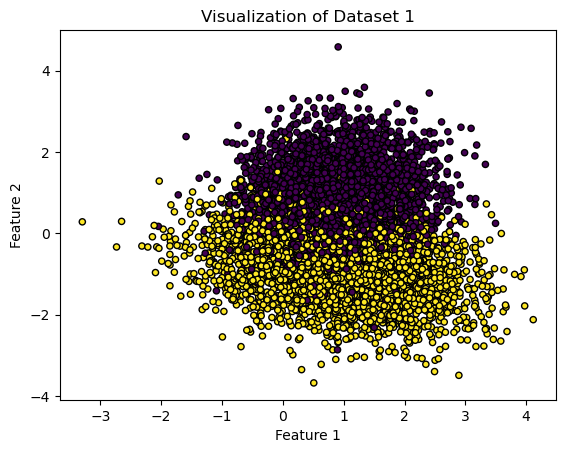

In [6]:
plot_dataset(x_train, y_train, 'Visualization of Dataset 1')

#### Comparison to Scikit-Learn's AdaBoost

In [7]:
custom_adaboost = test_fit_predict_custom(x_train, y_train, x_test, y_test)

Accuracy of Our AdaBoost: 86.35%


Tree: Train accuracy=87.71%, Test accuracy=86.35%


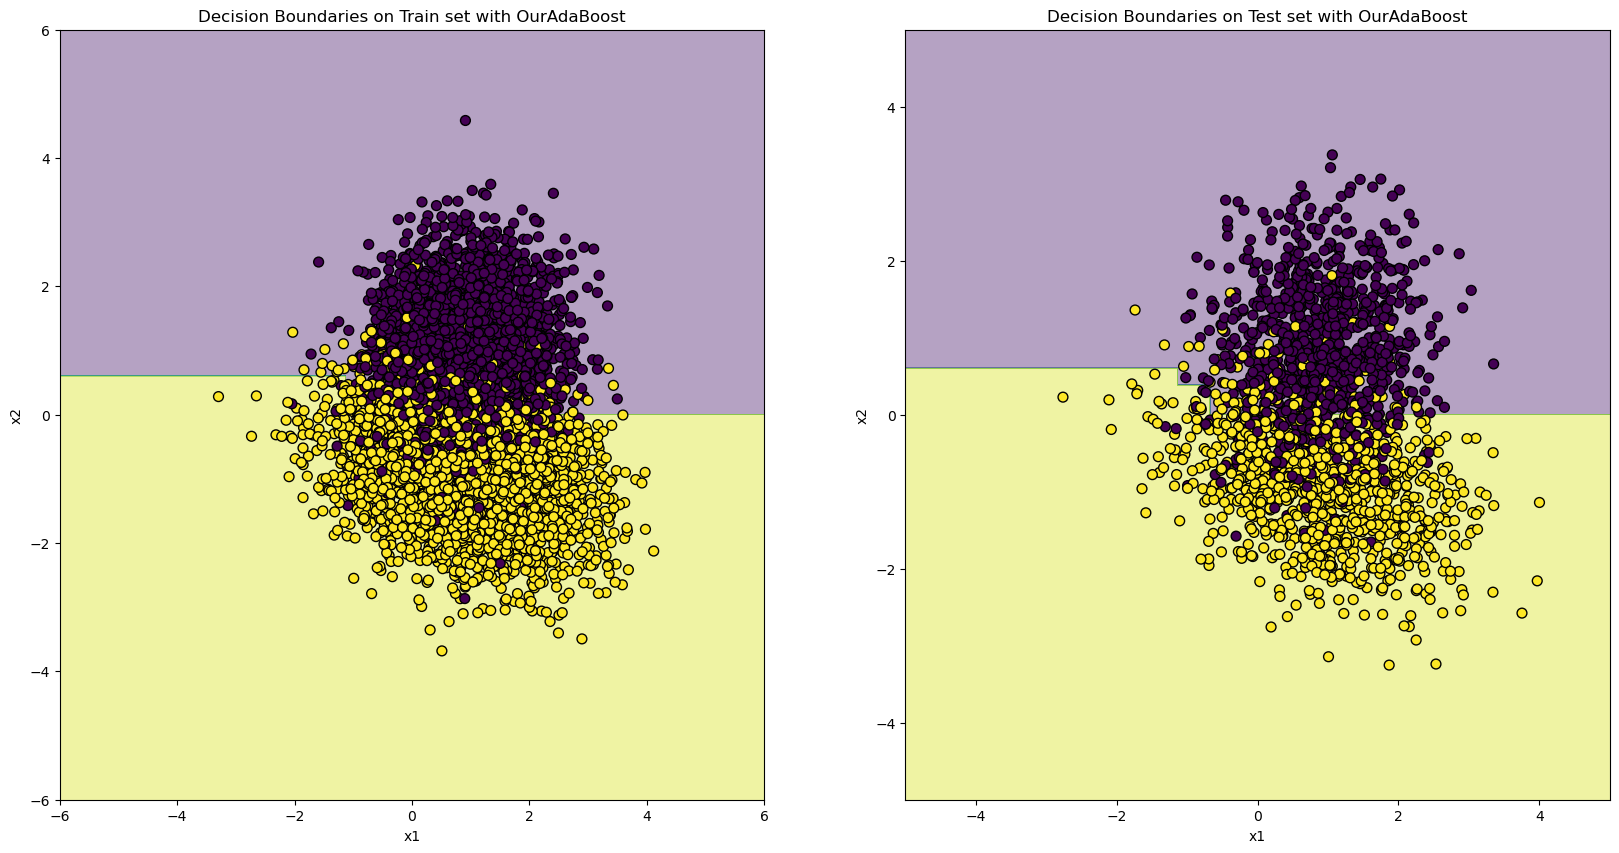

In [8]:
plot_decision_boundaries_comparison(x_train, y_train, x_test, y_test, custom_adaboost, ['x1', 'x2'])

In [9]:
sklearn_adaboost = test_fit_predict_sklearn(x_train, y_train, x_test, y_test)

Accuracy of Scikit-Learn's AdaBoost: 86.50%


Tree: Train accuracy=88.05%, Test accuracy=86.50%


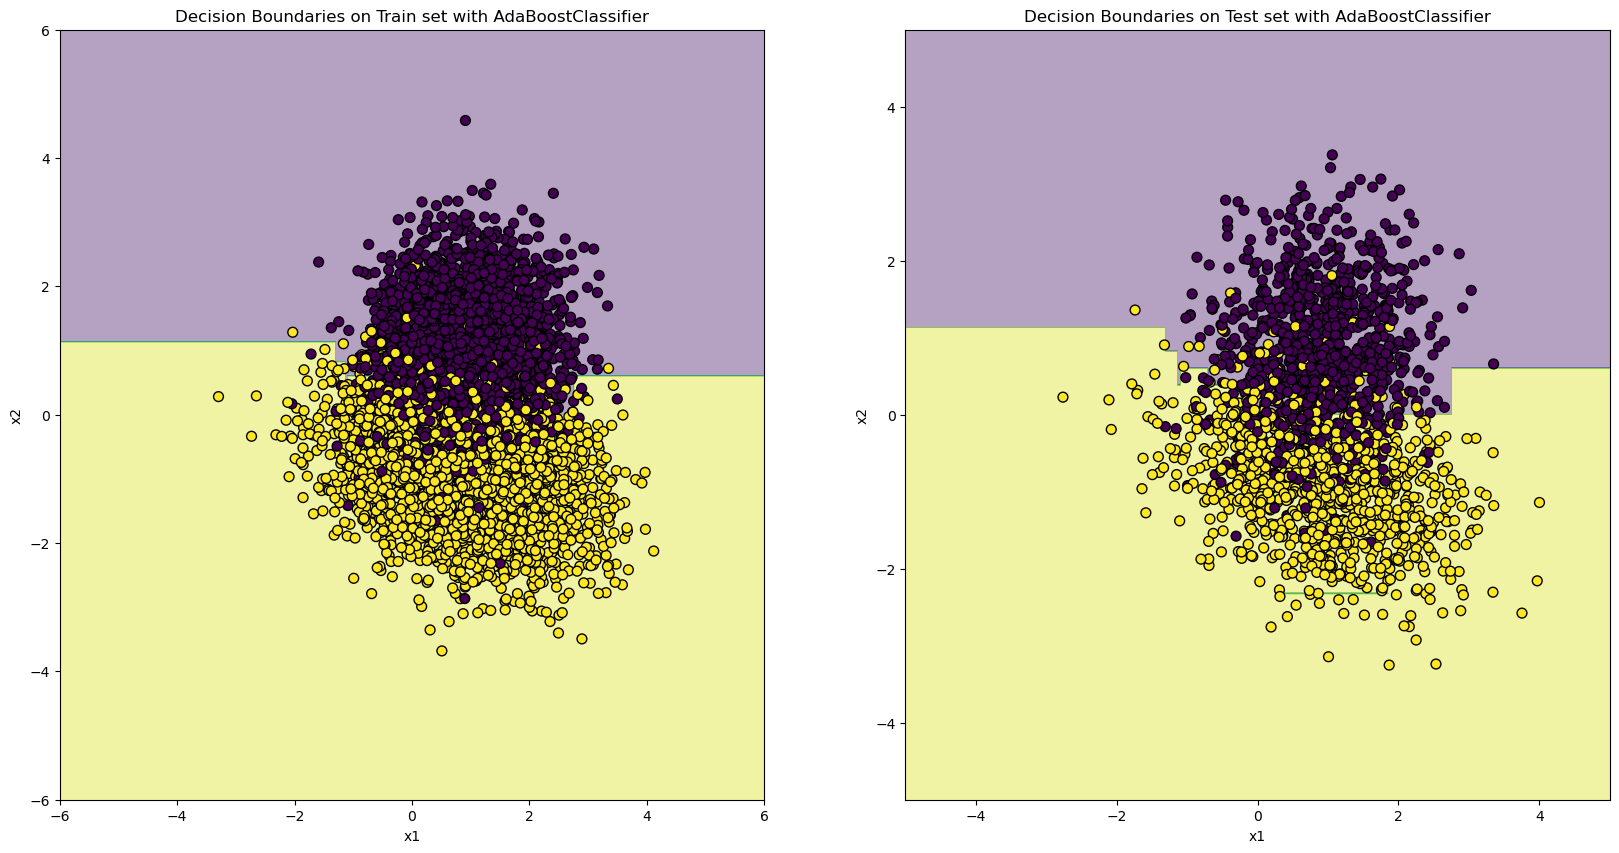

In [10]:
plot_decision_boundaries_comparison(x_train, y_train, x_test, y_test, sklearn_adaboost, ['x1', 'x2'])

### Second dataset

In [11]:
# Generate two datasets with one binary label
# Dataset 1
X1, y1 = make_classification(n_samples=2000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
# Dataset 2
X2, y2 = make_classification(n_samples=2000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=24)

# Concatenate datasets
X = np.concatenate([X1, X2], axis=0)
y = np.concatenate([y1, y2], axis=0)
y = np.where(y==0,-1,1)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
data = {'x_train': [len(x_train)],
        'x_test': [len(x_test)],
        'y_train': [len(y_train)],
        'y_test': [len(y_test)]}

df = pd.DataFrame(data, index=['Amount Dataset 2'])

print(df.to_markdown())

|                  |   x_train |   x_test |   y_train |   y_test |
|:-----------------|----------:|---------:|----------:|---------:|
| Amount Dataset 1 |      3200 |      800 |      3200 |      800 |


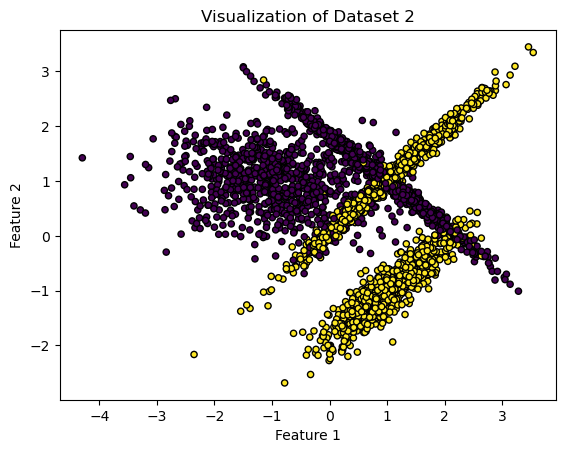

In [13]:
plot_dataset(x_train, y_train, 'Visualization of Dataset 2')

#### Comparison to Scikit-Learn's AdaBoost

In [14]:
custom_adaboost = test_fit_predict_custom(x_train, y_train, x_test, y_test)

Accuracy of Our AdaBoost: 73.12%


Tree: Train accuracy=77.31%, Test accuracy=73.12%


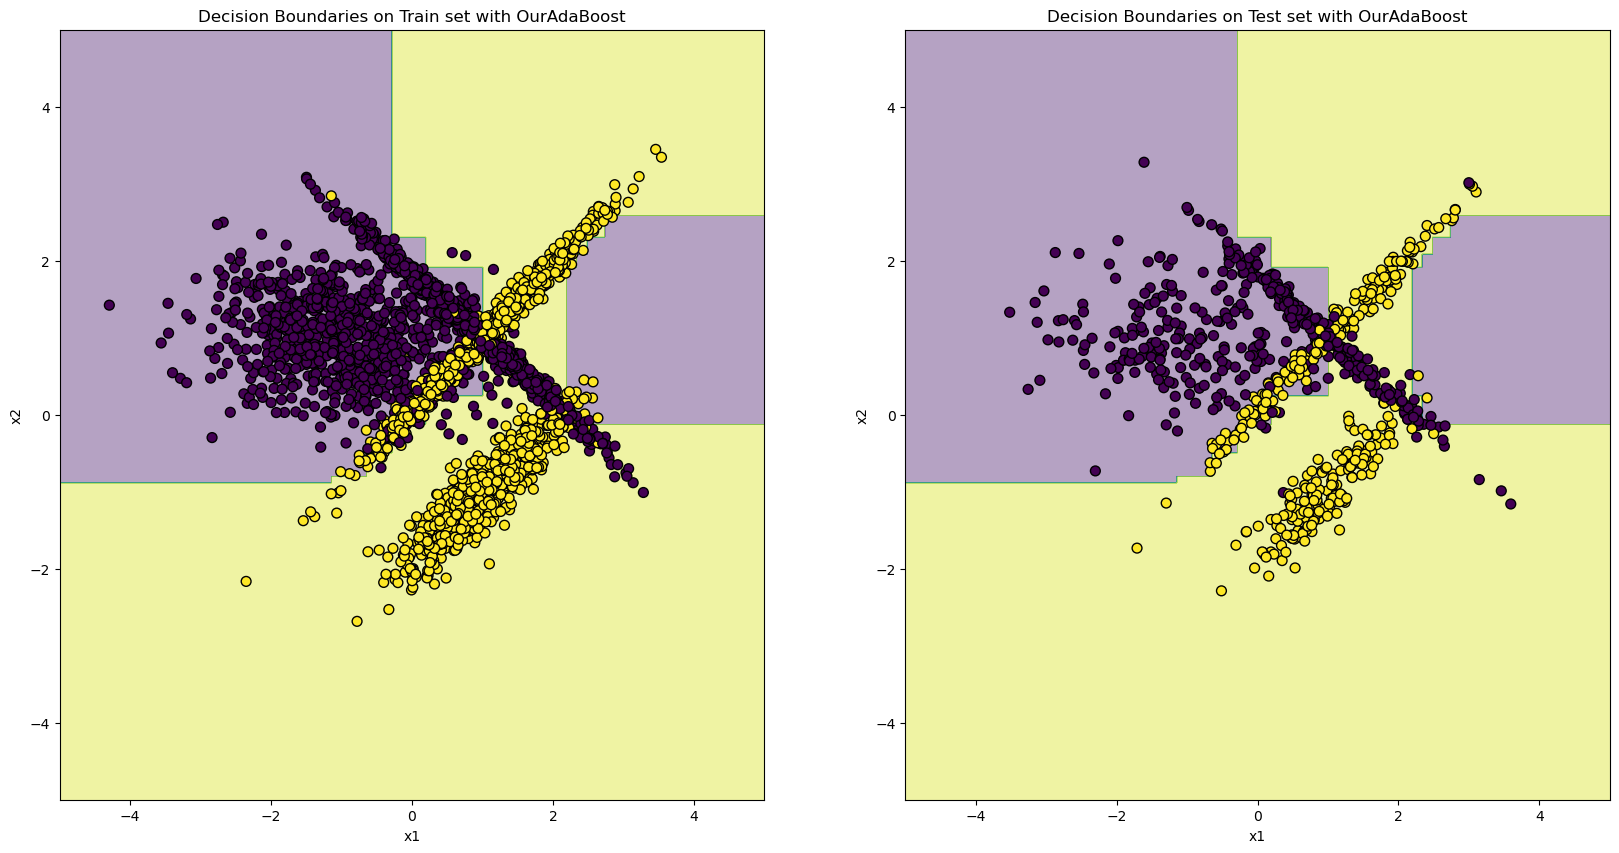

In [15]:
plot_decision_boundaries_comparison(x_train, y_train, x_test, y_test, custom_adaboost, ['x1', 'x2'])

In [16]:
sklearn_adaboost = test_fit_predict_sklearn(x_train, y_train, x_test, y_test)

Accuracy of Scikit-Learn's AdaBoost: 72.88%


Tree: Train accuracy=78.44%, Test accuracy=72.88%


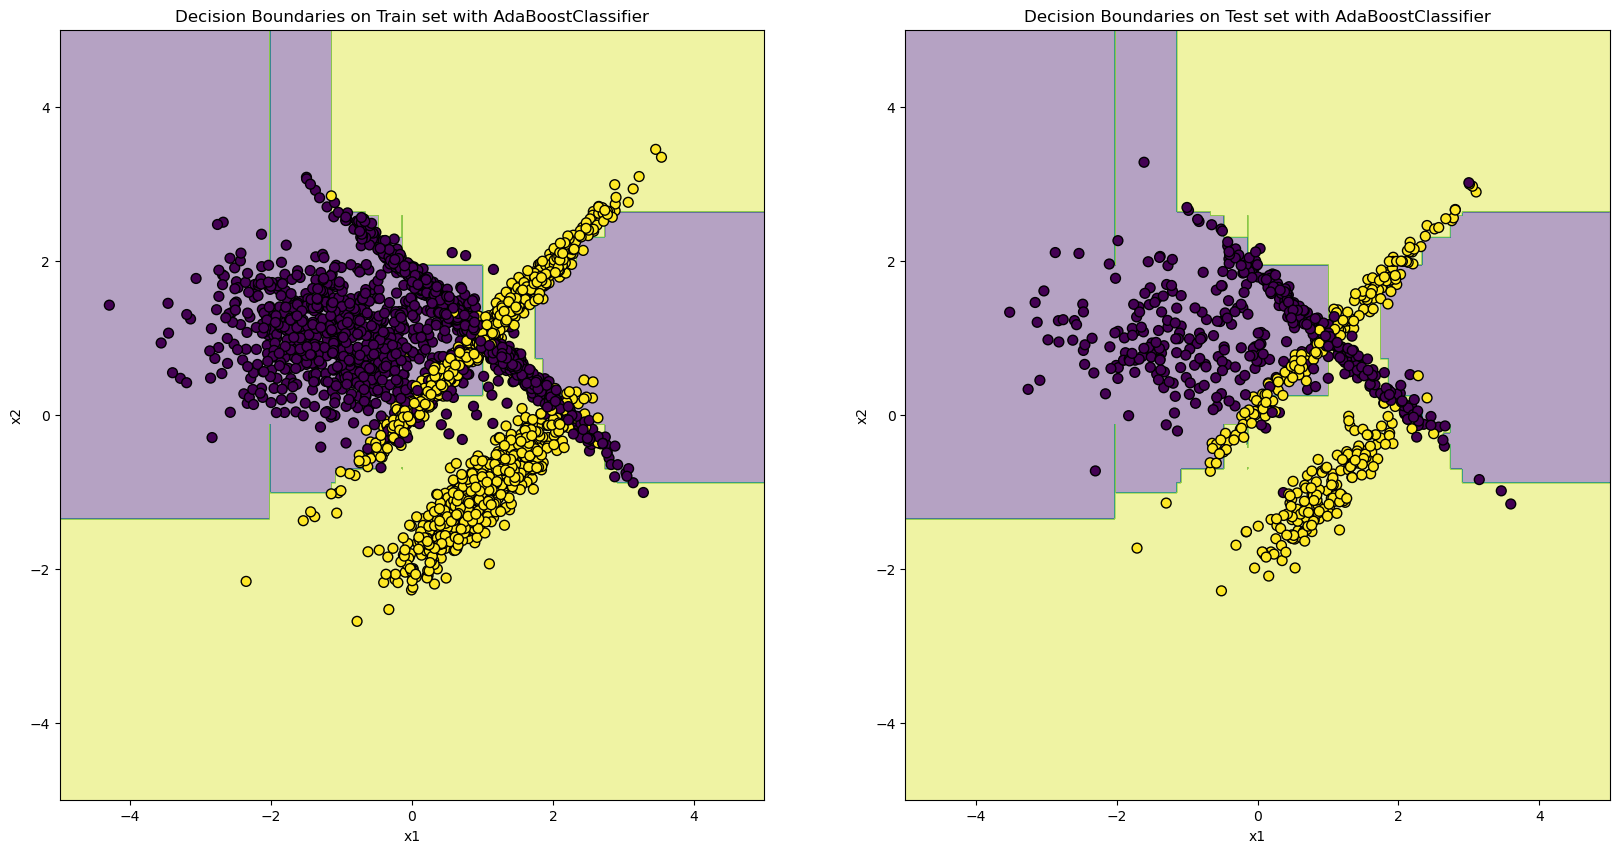

In [17]:
plot_decision_boundaries_comparison(x_train, y_train, x_test, y_test, sklearn_adaboost, ['x1', 'x2'])

# Part 2: Experiments
4. Generate experimental datasets.
* Generate at least two datasets with one binary label.
Note: these datasets should be designed so that they help you demonstrate the properties
of AdaBoost compared to other models.
* Split the data to train and test sets.
* Visualize the data.
Note: you can use dimensionality reduction if needed.
5. Design and perform experiments to test your model.
* Use proper performance measures.
* Compare the results to other models.

  Notes:
    * In addition to comparing to an existing implementation of AdaBoost, you should
  compare to at least two more classification models.
    * use exiting implementation for the other models.

* Present and summarize the results of the experiments using relevant plots/tables.
* Discuss the results and the effect of different properties of the dataset.

In [18]:
def evaluate_model(y_true, y_pred, n_estimators, learning_rate):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Print or store results
    print(f"Hyperparameters: n_estimators={n_estimators}, learning_rate={learning_rate}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score:: {f1:.2f}")
    print()

    return accuracy, precision, recall, f1


def plot_accuracy_distribution(X, y, num_trees_list, random_state=42, cv=5):
    """
    Plot the box and whisker plot for the distribution of accuracy scores for each configured number of trees in AdaBoost.
    """

    models = {str(num_trees): OurAdaBoost(n_estimators=num_trees, random_state=random_state) for num_trees in num_trees_list}

    accuracies = {name: cross_val_score(model, X, y, cv=cv, scoring='accuracy') for name, model in models.items()}

    # Create a box and whisker plot with y-axis starting from zero
    plt.figure(figsize=(10, 6))
    plt.boxplot(accuracies.values(), labels=accuracies.keys(), showmeans=True)
    plt.title('Accuracy Distribution for Different Numbers of Trees in AdaBoost')
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.show()


def plot_model_comparison(models, metrics_dict, bar_width=0.4):
    """
    Plot comparison of model performance for given metrics.
    """

    # Create DataFrame for Seaborn
    data = {'Model': [], 'Metric': [], 'Value': []}
    for model, metrics in metrics_dict.items():
        for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
            data['Model'].append(model)
            data['Metric'].append(metric)
            data['Value'].append(metrics[i])
    df = pd.DataFrame(data)

    # Plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Value', hue='Metric', data=df, palette='Set3', ci=None, dodge=True)

    # Add value annotations on top of each bar
    for patch in plt.gca().patches:
        height = patch.get_height()
        plt.gca().annotate(f'{height:.2f}', (patch.get_x() + patch.get_width() / 2, height),
                           ha='center', va='bottom', fontsize=9)

    plt.xlabel('Models')
    plt.ylabel('Metrics')
    plt.title('Comparison of Model Performance')
    plt.legend(title='Metrics', loc='lower right')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, classifier_name):
    """
    Plot the confusion matrix for a classifier.
    """

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plotting the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title(f"Confusion Matrix - {classifier_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [19]:
def visualize_data_with_dr(X, y, title):
    # Perform PCA for dimensionality reduction to 2D
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    # Plot the data
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=40)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()


def plot_decision_boundaries_with_dr(ax, X, y, title_pref, clf, feature_names, resolution=0.01):
    # Perform PCA for dimensionality reduction to 2D
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)

    # Plot the decision surface
    axis_max = abs(X_pca).max().round() + 1

    # Reduce dimention to 2D with PCA
    xx, yy = np.meshgrid(np.arange(-axis_max, axis_max, resolution),
                         np.arange(-axis_max, axis_max, resolution))
    meshgrid_original = np.c_[xx.ravel(), yy.ravel()]
    meshgrid_transformed = pca.inverse_transform(meshgrid_original)

    # Transform the data back to high demention for classification
    Z = clf.predict(meshgrid_transformed)
    Z = Z.reshape(xx.shape)
    contour = ax.contourf(xx, yy, Z, alpha=0.4)

    # Plot class samples
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=50, edgecolors='k')

    # Add legend
    legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
    ax.add_artist(legend1)

    ax.set_xlim(-axis_max, axis_max)
    ax.set_ylim(-axis_max, axis_max)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(f"Decision Boundaries on {title_pref} set with {clf.__class__.__name__} + PCA for DR to 2D")

    return ax


def plot_decision_boundaries_comparison_with_dr(x_train, y_train, x_test, y_test, adaboost, feature_names):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    print(f'Tree: Train accuracy={adaboost.score(x_train, y_train):.2%}, Test accuracy={adaboost.score(x_test, y_test):.2%}')
    for ax, data, label in zip(axs, [(x_train, y_train), (x_test, y_test)], ['Train', 'Test']):
        plot_decision_boundaries_with_dr(ax, data[0], data[1], label, adaboost, feature_names)

    plt.show()


### Create two Datasets

In [20]:
# 1) Create a dataset with non linear seperation and some noise
X_1, y_1 = make_classification(
    n_samples=2000,
    n_features=10,
    n_informative=7,
    n_classes=2,
    class_sep=1.5,
    flip_y=0.1,  # Introduce some noise
    random_state=98
)

y_1 = np.where(y_1==0,-1,1)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

# 2) Create an imbalanced dataset with some noise and linear seperation
X_2, y_2 = make_classification(
    n_samples=2000,
    n_features=10,
    n_informative=7,
    n_redundant=3,
    weights=[0.7, 0.3],  # 70% samples from class 0, 30% from class 1
    n_clusters_per_class=1,
    flip_y=0.18,  # Introduce some noise
    class_sep=2,
    n_classes=2,
    random_state=2
)

y_2 = np.where(y_2==0,-1,1)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [21]:
data = {'x_train': [len(x_train_1)],
        'x_test': [len(x_test_1)],
        'y_train': [len(y_train_1)],
        'y_test': [len(y_test_1)]}

df = pd.DataFrame(data, index=['Amount Dataset 1'])

print(df.to_markdown())

|                  |   x_train |   x_test |   y_train |   y_test |
|:-----------------|----------:|---------:|----------:|---------:|
| Amount Dataset 1 |      1600 |      400 |      1600 |      400 |


In [22]:
data = {'x_train': [len(x_train_2)],
        'x_test': [len(x_test_2)],
        'y_train': [len(y_train_2)],
        'y_test': [len(y_test_2)]}

df = pd.DataFrame(data, index=['Amount Dataset 2'])

print(df.to_markdown())

|                  |   x_train |   x_test |   y_train |   y_test |
|:-----------------|----------:|---------:|----------:|---------:|
| Amount Dataset 2 |      1600 |      400 |      1600 |      400 |


## Visualizations & Hyperparameters Tuning

### First Dataset

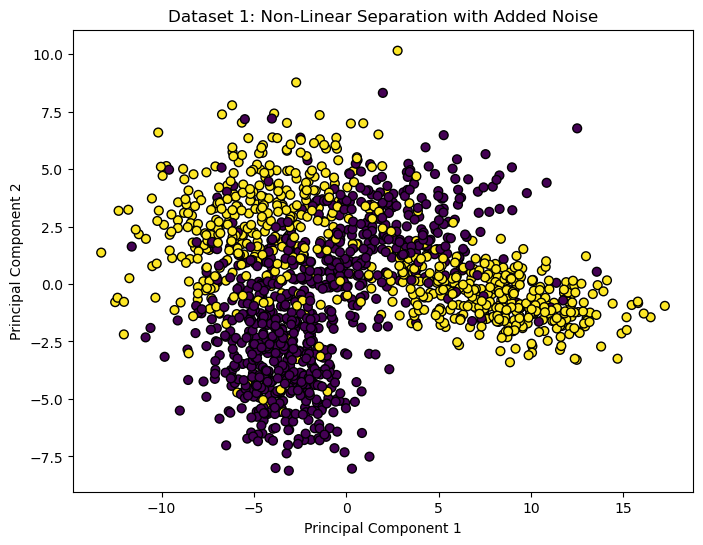

In [23]:
visualize_data_with_dr(x_train_1, y_train_1, 'Dataset 1: Non-Linear Separation with Added Noise')

In [24]:
# Define hyperparameter combinations to try
n_estimators_values = [1, 5, 10, 25, 50, 100, 150, 200]
learning_rate_values = [0.001, 0.01, 0.1, 0.5, 0.9, 1.0]

best_accuracy_1, best_precision_1, best_recall_1, best_f1_1 = 0.0, 0.0, 0.0, 0.0
best_params_1 = {}

# Perform grid search
for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        # Train AdaBoost with current hyperparameters
        ada_clf = OurAdaBoost(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
        ada_clf.fit(x_train_1, y_train_1)

        # Evaluate performance
        y_pred = ada_clf.predict(x_test_1)
        accuracy, precision, recall, f1 = evaluate_model(y_test_1, y_pred, n_estimators, learning_rate)

        # Check if current combination is the best
        if accuracy > best_accuracy_1 or (accuracy == best_accuracy_1 and f1 > best_f1_1):
            best_accuracy_1, best_precision_1, best_recall_1, best_f1_1 = accuracy, precision, recall, f1
            best_params_1 = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

Hyperparameters: n_estimators=1, learning_rate=0.001
Accuracy: 0.69
Precision: 0.64
Recall: 0.93
F1 Score:: 0.76

Hyperparameters: n_estimators=1, learning_rate=0.01
Accuracy: 0.69
Precision: 0.64
Recall: 0.93
F1 Score:: 0.76

Hyperparameters: n_estimators=1, learning_rate=0.1
Accuracy: 0.69
Precision: 0.64
Recall: 0.93
F1 Score:: 0.76

Hyperparameters: n_estimators=1, learning_rate=0.5
Accuracy: 0.69
Precision: 0.64
Recall: 0.93
F1 Score:: 0.76

Hyperparameters: n_estimators=1, learning_rate=0.9
Accuracy: 0.69
Precision: 0.64
Recall: 0.93
F1 Score:: 0.76

Hyperparameters: n_estimators=1, learning_rate=1.0
Accuracy: 0.69
Precision: 0.64
Recall: 0.93
F1 Score:: 0.76

Hyperparameters: n_estimators=5, learning_rate=0.001
Accuracy: 0.69
Precision: 0.64
Recall: 0.93
F1 Score:: 0.76

Hyperparameters: n_estimators=5, learning_rate=0.01
Accuracy: 0.69
Precision: 0.64
Recall: 0.93
F1 Score:: 0.76

Hyperparameters: n_estimators=5, learning_rate=0.1
Accuracy: 0.69
Precision: 0.64
Recall: 0.93
F1 

In [25]:
# Print the best hyperparameters
print("Best Imbalanced Noisy Hyperparameters:", best_params_1)
print(f"Accuracy: {best_accuracy_1:.2f}")
print(f"Precision: {best_precision_1:.2f}")
print(f"Recall: {best_recall_1:.2f}")
print(f"F1 Score:: {best_f1_1:.2f}")

Best Imbalanced Noisy Hyperparameters: {'n_estimators': 200, 'learning_rate': 1.0}
Accuracy: 0.89
Precision: 0.87
Recall: 0.92
F1 Score:: 0.89


In [26]:
ada_clf = OurAdaBoost(n_estimators=best_params_1['n_estimators'], learning_rate=best_params_1['learning_rate'], random_state=42)
ada_clf.fit(x_train_1, y_train_1)

Tree: Train accuracy=90.38%, Test accuracy=89.00%


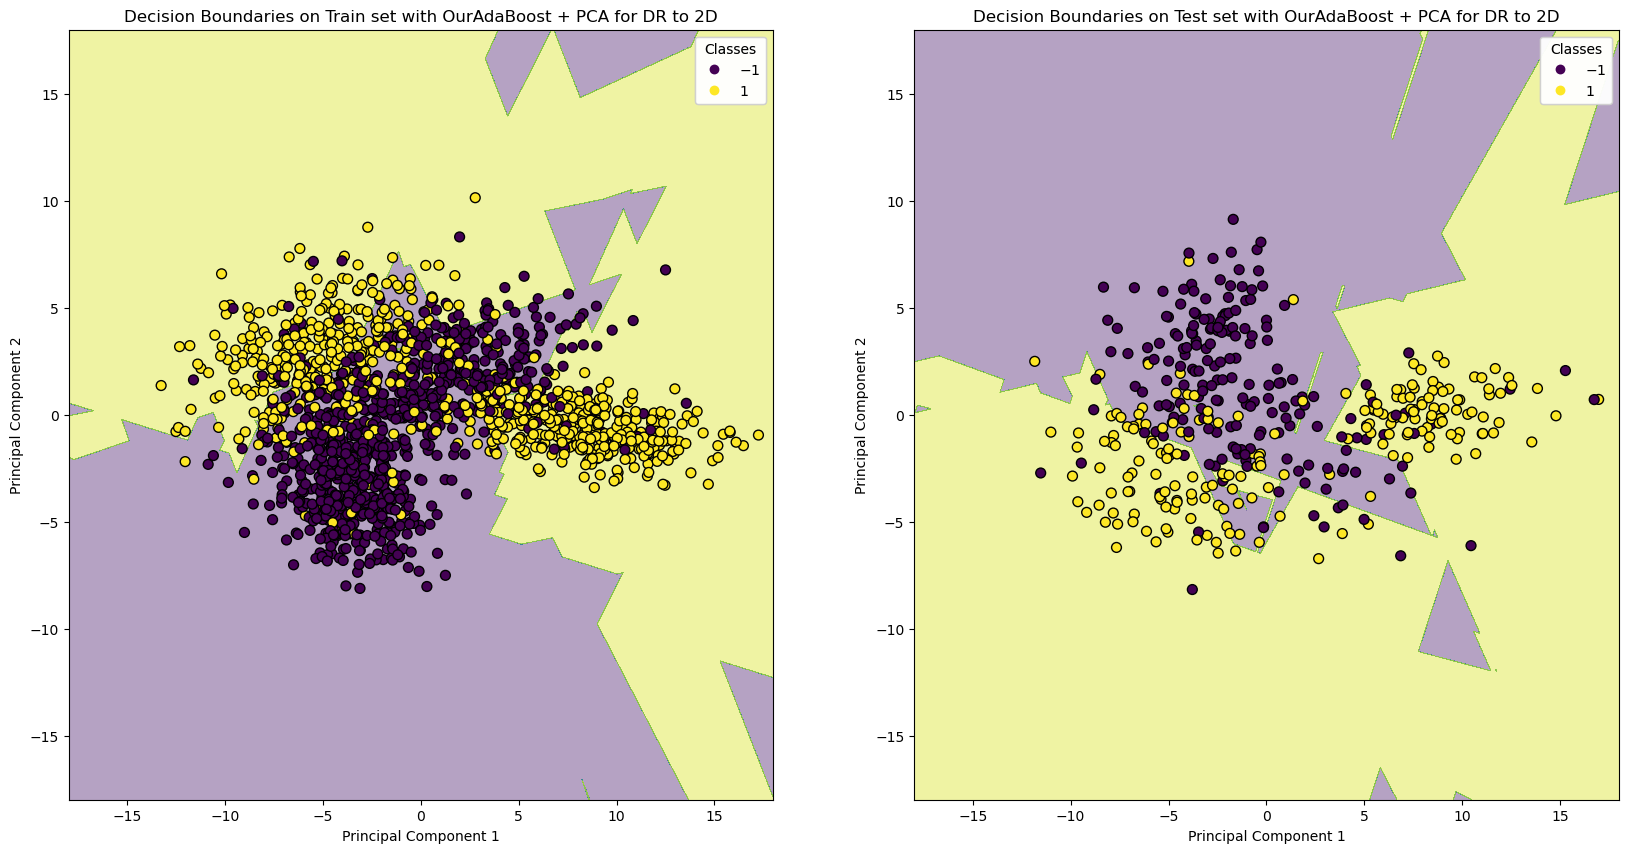

In [27]:
plot_decision_boundaries_comparison_with_dr(x_train_1, y_train_1, x_test_1, y_test_1, ada_clf, ['x1', 'x2'])

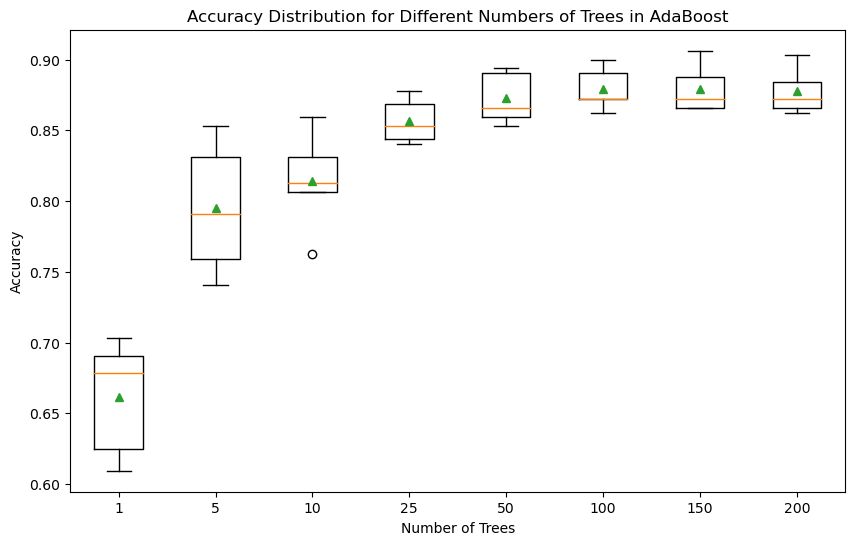

In [28]:
plot_accuracy_distribution(x_train_1, y_train_1, num_trees_list=n_estimators_values)

### Second dataset


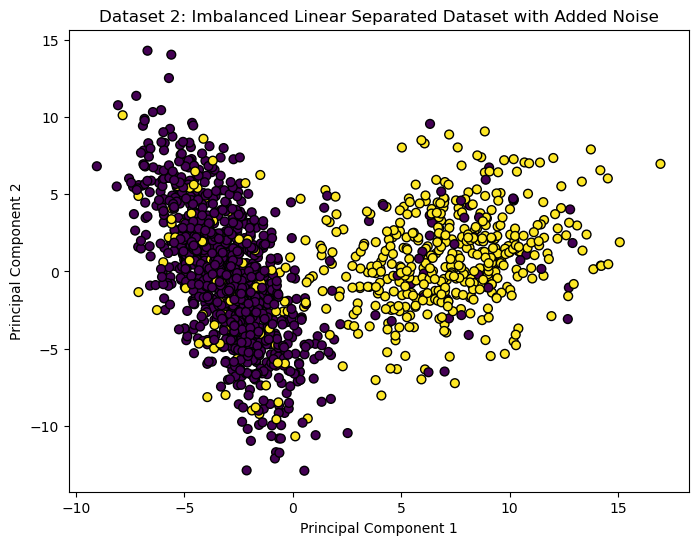

In [29]:
visualize_data_with_dr(x_train_2, y_train_2, 'Dataset 2: Imbalanced Linear Separated Dataset with Added Noise')

In [30]:
# Define hyperparameter combinations to try
n_estimators_values = [1, 5, 10, 25, 50, 100, 150, 200]
learning_rate_values = [0.001, 0.01, 0.1, 0.5, 0.9, 1.0]

best_accuracy_2, best_precision_2, best_recall_2, best_f1_2 = 0.0, 0.0, 0.0, 0.0
best_params_2 = {}

# Perform grid search
for n_estimators in n_estimators_values:
    for learning_rate in learning_rate_values:
        # Train AdaBoost with current hyperparameters
        ada_clf = OurAdaBoost(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
        ada_clf.fit(x_train_2, y_train_2)

        # Evaluate performance
        y_pred = ada_clf.predict(x_test_2)
        accuracy, precision, recall, f1 = evaluate_model(y_test_2, y_pred, n_estimators, learning_rate)

        # Check if current combination is the best
        if accuracy > best_accuracy_2 or (accuracy == best_accuracy_2 and f1 > best_f1_2):
            best_accuracy_2, best_precision_2, best_recall_2, best_f1_2 = accuracy, precision, recall, f1
            best_params_2 = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

Hyperparameters: n_estimators=1, learning_rate=0.001
Accuracy: 0.87
Precision: 0.85
Recall: 0.75
F1 Score:: 0.80

Hyperparameters: n_estimators=1, learning_rate=0.01
Accuracy: 0.87
Precision: 0.85
Recall: 0.75
F1 Score:: 0.80

Hyperparameters: n_estimators=1, learning_rate=0.1
Accuracy: 0.87
Precision: 0.85
Recall: 0.75
F1 Score:: 0.80

Hyperparameters: n_estimators=1, learning_rate=0.5
Accuracy: 0.87
Precision: 0.85
Recall: 0.75
F1 Score:: 0.80

Hyperparameters: n_estimators=1, learning_rate=0.9
Accuracy: 0.87
Precision: 0.85
Recall: 0.75
F1 Score:: 0.80

Hyperparameters: n_estimators=1, learning_rate=1.0
Accuracy: 0.87
Precision: 0.85
Recall: 0.75
F1 Score:: 0.80

Hyperparameters: n_estimators=5, learning_rate=0.001
Accuracy: 0.87
Precision: 0.85
Recall: 0.75
F1 Score:: 0.80

Hyperparameters: n_estimators=5, learning_rate=0.01
Accuracy: 0.87
Precision: 0.85
Recall: 0.75
F1 Score:: 0.80

Hyperparameters: n_estimators=5, learning_rate=0.1
Accuracy: 0.89
Precision: 0.88
Recall: 0.75
F1 

In [31]:
# Print the best hyperparameters
print("Best Non Linear Noisy Hyperparameters:", best_params_2)
print(f"Accuracy: {best_accuracy_2:.2f}")
print(f"Precision: {best_precision_2:.2f}")
print(f"Recall: {best_recall_2:.2f}")
print(f"F1 Score:: {best_f1_2:.2f}")

Best Non Linear Noisy Hyperparameters: {'n_estimators': 50, 'learning_rate': 1.0}
Accuracy: 0.92
Precision: 0.92
Recall: 0.82
F1 Score:: 0.87


In [32]:
ada_clf = OurAdaBoost(n_estimators=best_params_2['n_estimators'], learning_rate=best_params_2['learning_rate'])
ada_clf.fit(x_train_2, y_train_2)

Tree: Train accuracy=90.75%, Test accuracy=91.50%


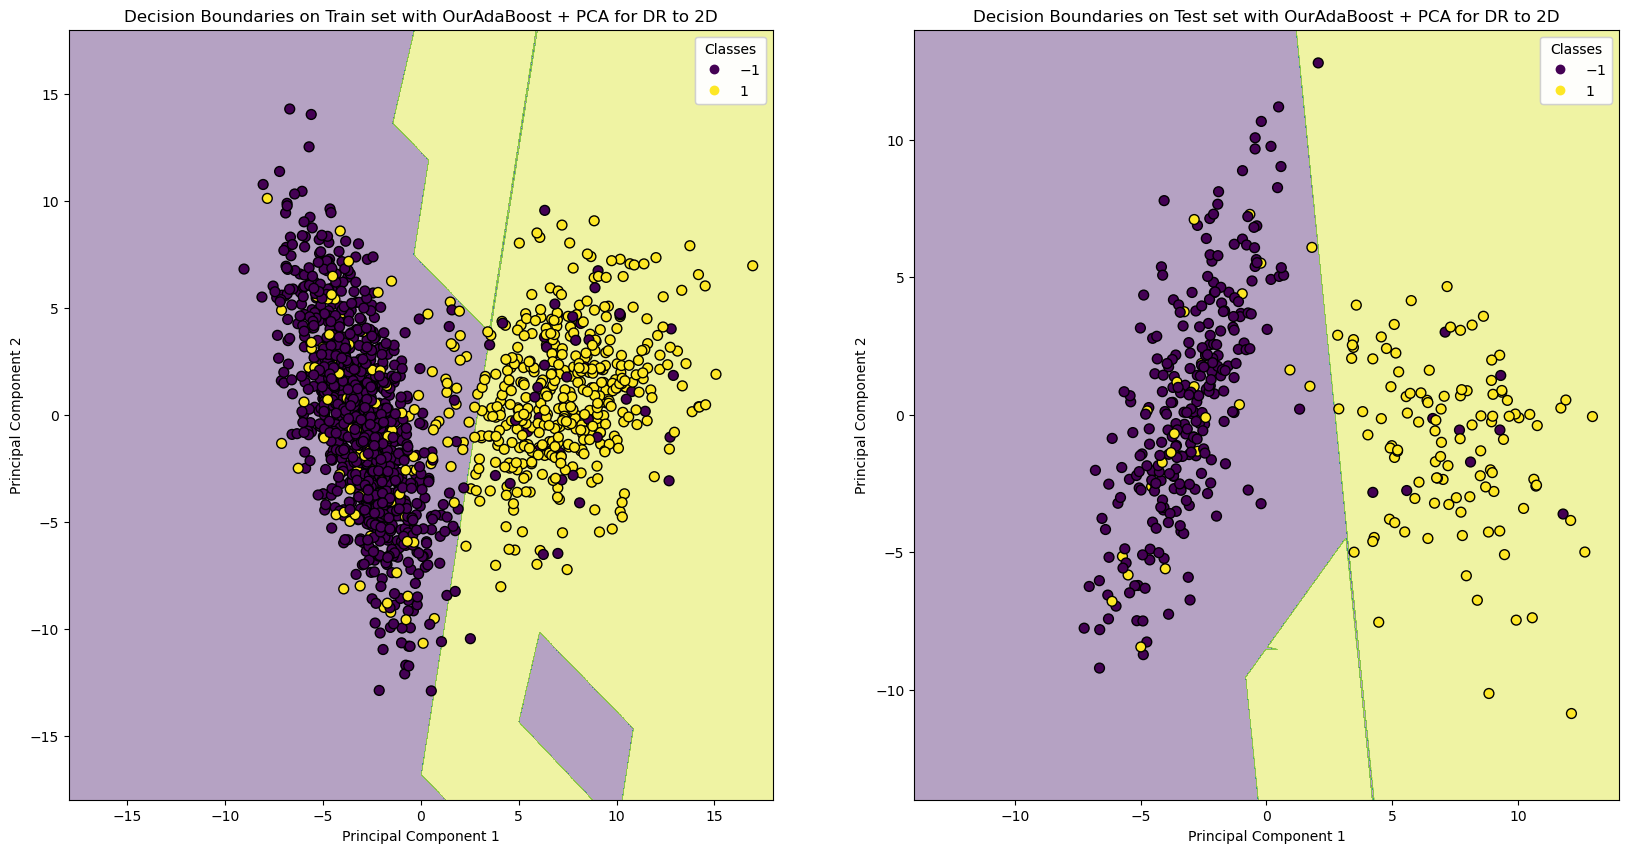

In [33]:
plot_decision_boundaries_comparison_with_dr(x_train_2, y_train_2, x_test_2, y_test_2, ada_clf, ['x1', 'x2'])

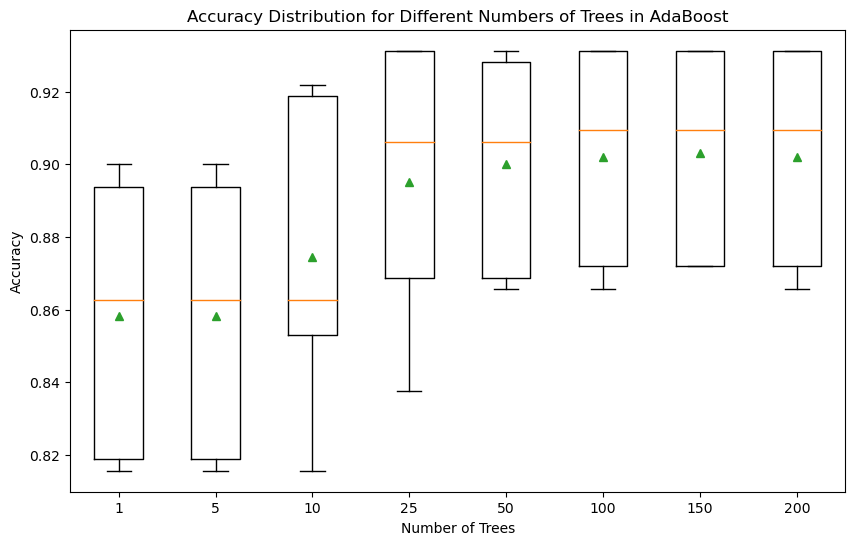

In [34]:
plot_accuracy_distribution(x_train_2, y_train_2, num_trees_list=n_estimators_values)

## Comparison with other models

In [35]:
def train_models(x_train, y_train, best_params):
    # Train Our AdaBoost
    our_ada_clf = OurAdaBoost(n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'], random_state=42)
    our_ada_clf.fit(x_train, y_train)

    # Train Our AdaBoost
    ada_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
    ada_clf.fit(x_train, y_train)

    # Train Linear SVM
    svm_clf = LinearSVC(C=1)
    svm_clf.fit(x_train, y_train)

    # Train Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(x_train, y_train)

    return our_ada_clf, ada_clf, svm_clf, rf_clf

def predict_models(models, x_test):
    our_ada_clf, ada_clf, svm_clf, rf_clf = models
    y_predict_our_ada = our_ada_clf.predict(x_test)
    y_pred_ada = ada_clf.predict(x_test)
    y_pred_svm = svm_clf.predict(x_test)
    y_pred_rf = rf_clf.predict(x_test)

    return y_predict_our_ada, y_pred_ada, y_pred_svm, y_pred_rf

def evaluate_models(y_true, y_preds):
    metrics_our_ada = [accuracy_score(y_true, y_preds[0]),
                       precision_score(y_true, y_preds[0]),
                       recall_score(y_true, y_preds[0]),
                       f1_score(y_true, y_preds[0])]

    metrics_ada = [accuracy_score(y_true, y_preds[1]),
                   precision_score(y_true, y_preds[1]),
                   recall_score(y_true, y_preds[1]),
                   f1_score(y_true, y_preds[1])]

    metrics_svm = [accuracy_score(y_true, y_preds[2]),
                   precision_score(y_true, y_preds[2]),
                   recall_score(y_true, y_preds[2]),
                   f1_score(y_true, y_preds[2])]

    metrics_rf = [accuracy_score(y_true, y_preds[3]),
                  precision_score(y_true, y_preds[3]),
                  recall_score(y_true, y_preds[3]),
                  f1_score(y_true, y_preds[3])]

    models = ['OurAdaBoost', 'AdaBoostClassifier', 'Linear SVM', 'Random Forest']
    metrics_dict = {
        'OurAdaBoost': metrics_our_ada,
        'AdaBoostClassifier': metrics_ada,
        'Linear SVM': metrics_svm,
        'Random Forest': metrics_rf
    }

    return metrics_dict


### First Dataset

In [36]:
models = train_models(x_train_1, y_train_1, best_params_1)
y_preds = predict_models(models, x_test_1)
metrics_dict = evaluate_models(y_test_1, y_preds)

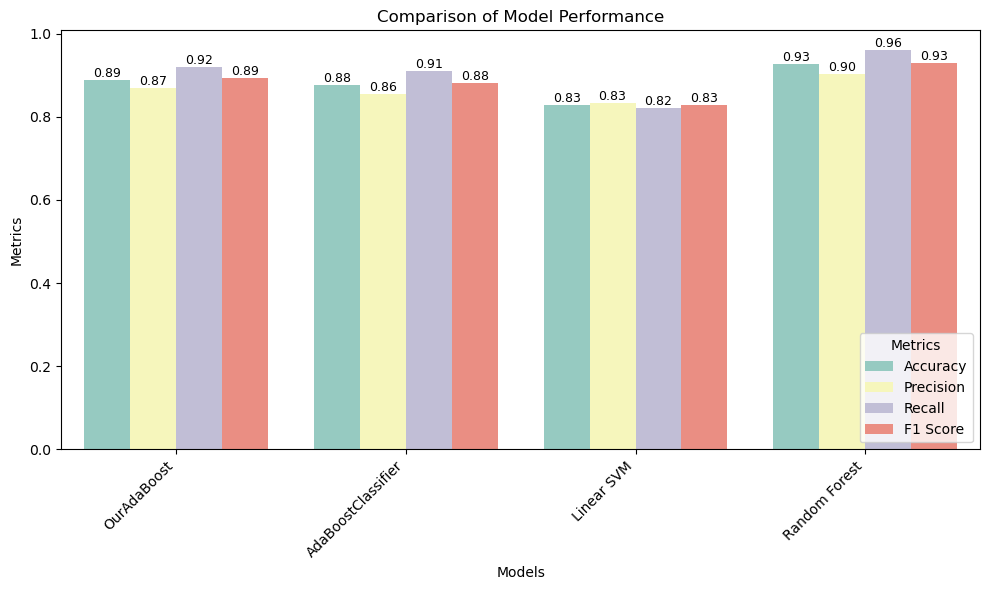

In [37]:
plot_model_comparison(models, metrics_dict)

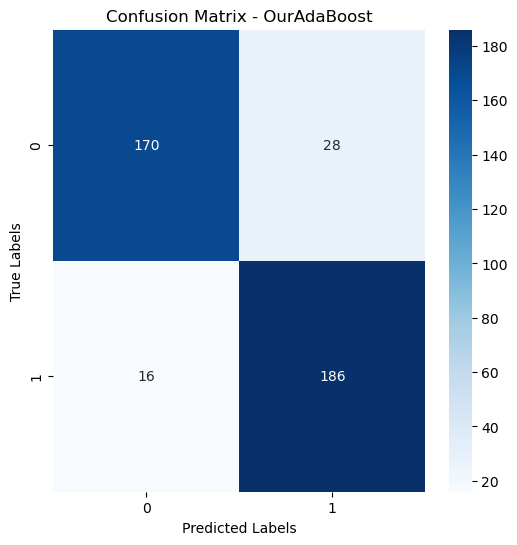

In [38]:
plot_confusion_matrix(y_test_1, y_preds[0], "OurAdaBoost")

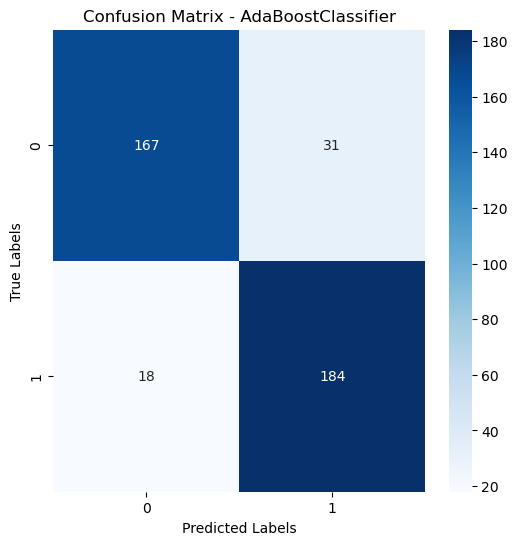

In [39]:
plot_confusion_matrix(y_test_1, y_preds[1], "AdaBoostClassifier")

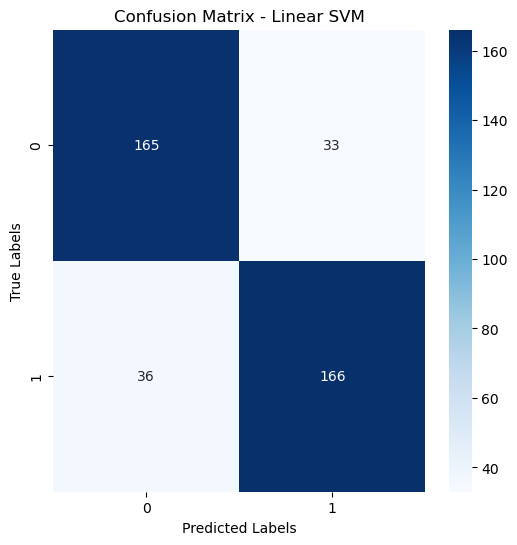

In [40]:
plot_confusion_matrix(y_test_1, y_preds[2], "Linear SVM")

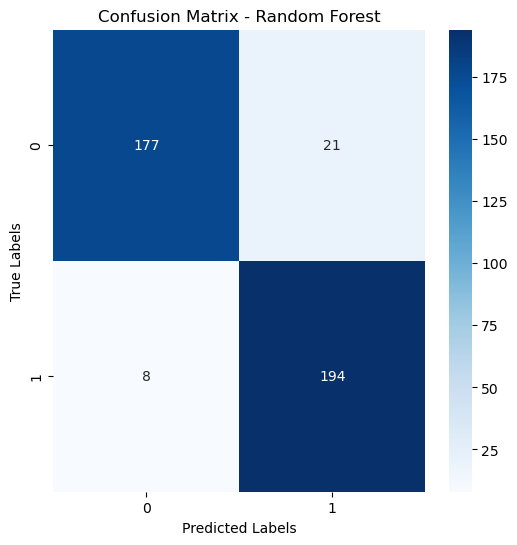

In [41]:
plot_confusion_matrix(y_test_1, y_preds[3], "Random Forest")

Tree: Train accuracy=90.38%, Test accuracy=89.00%


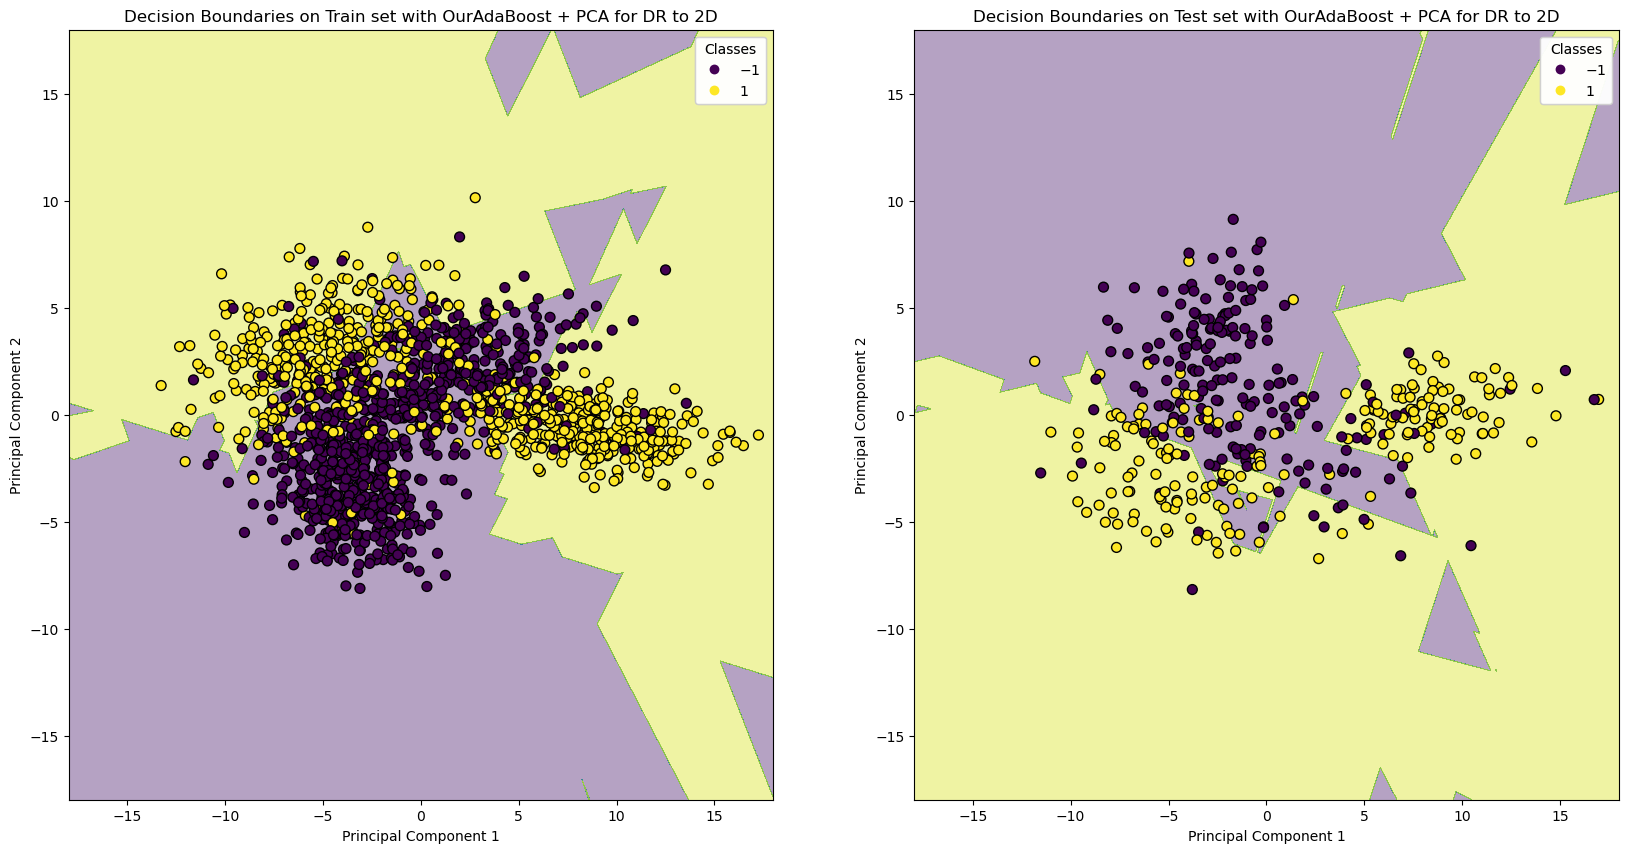

In [42]:
plot_decision_boundaries_comparison_with_dr(x_train_1, y_train_1, x_test_1, y_test_1, models[0], ['x1', 'x2'])

Tree: Train accuracy=91.25%, Test accuracy=87.75%


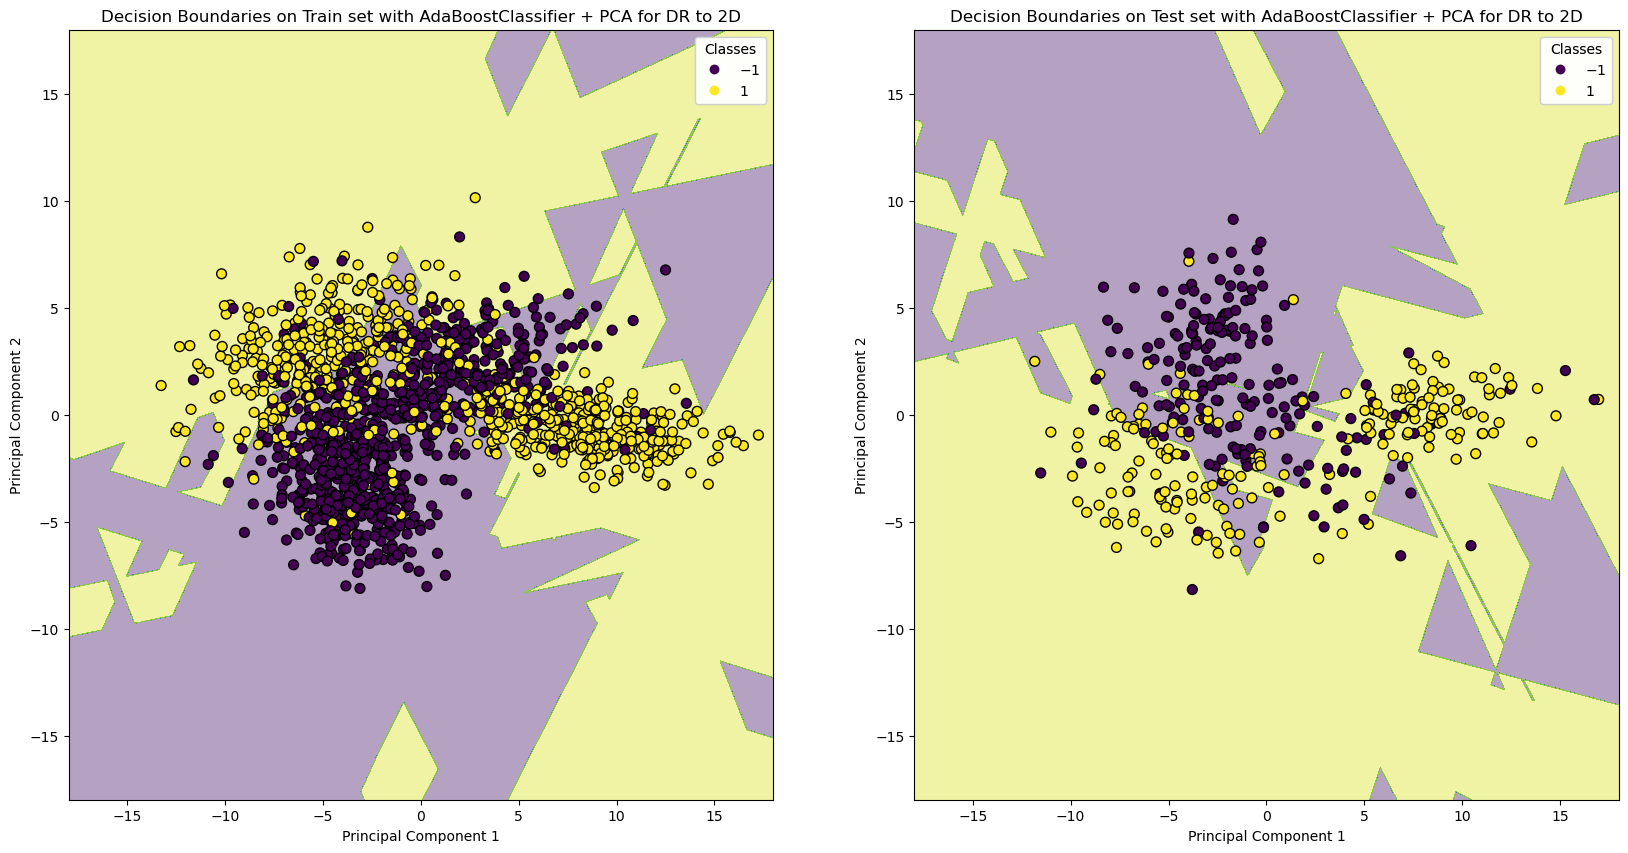

In [43]:
plot_decision_boundaries_comparison_with_dr(x_train_1, y_train_1, x_test_1, y_test_1, models[1], ['x1', 'x2'])

Tree: Train accuracy=82.25%, Test accuracy=82.75%


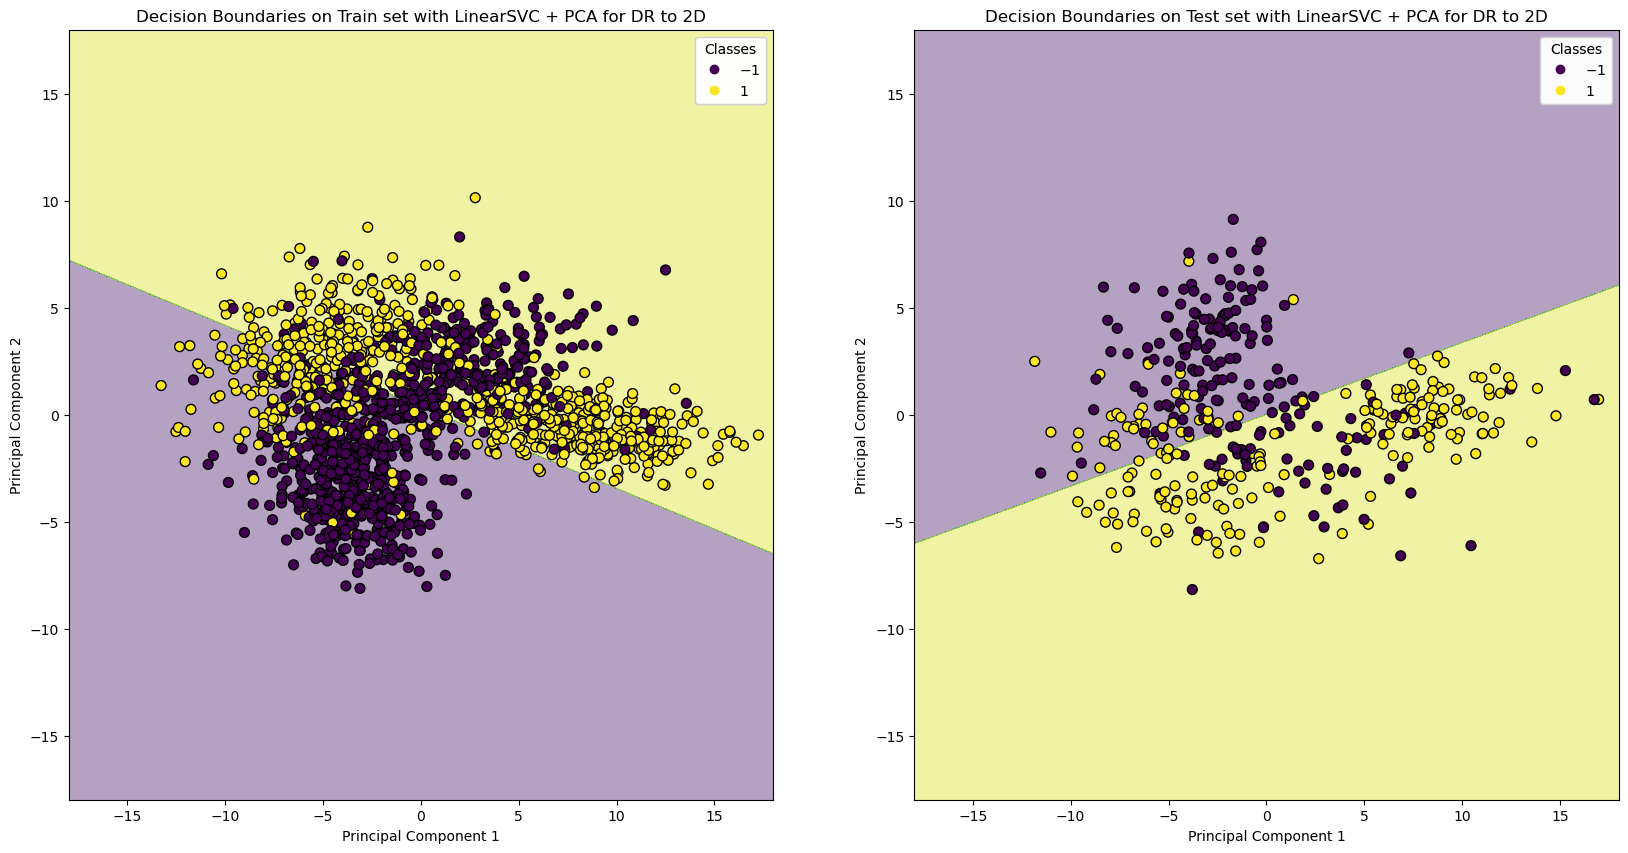

In [44]:
plot_decision_boundaries_comparison_with_dr(x_train_1, y_train_1, x_test_1, y_test_1, models[2], ['x1', 'x2'])

Tree: Train accuracy=100.00%, Test accuracy=92.75%


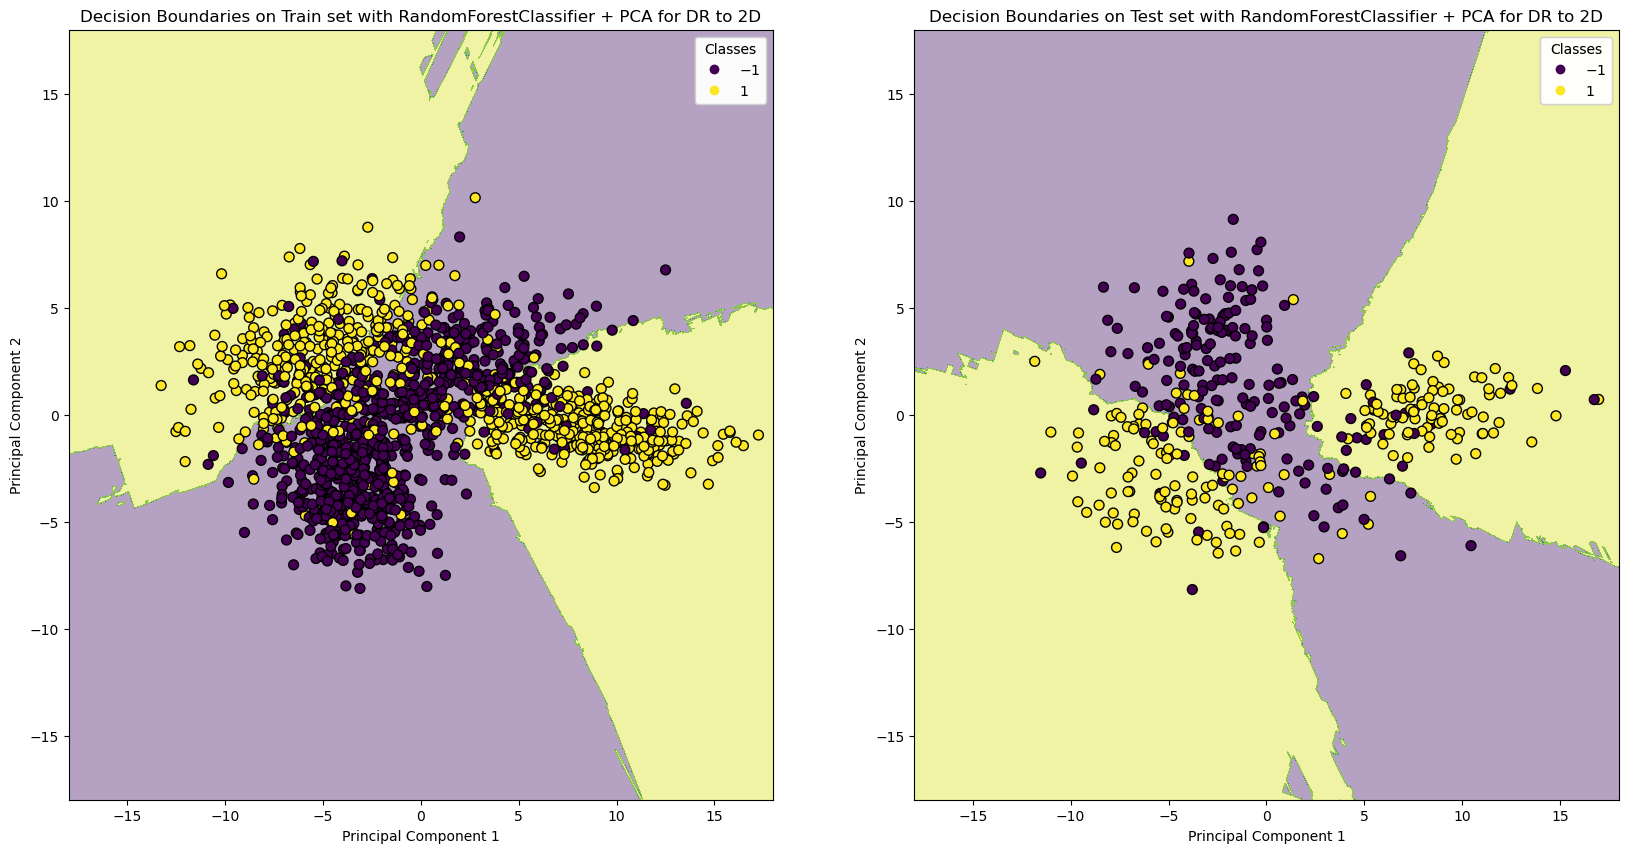

In [45]:
plot_decision_boundaries_comparison_with_dr(x_train_1, y_train_1, x_test_1, y_test_1, models[3], ['x1', 'x2'])

### Second Dataset

In [46]:
models = train_models(x_train_2, y_train_2, best_params_2)
y_preds = predict_models(models, x_test_2)
metrics_dict = evaluate_models(y_test_2, y_preds)

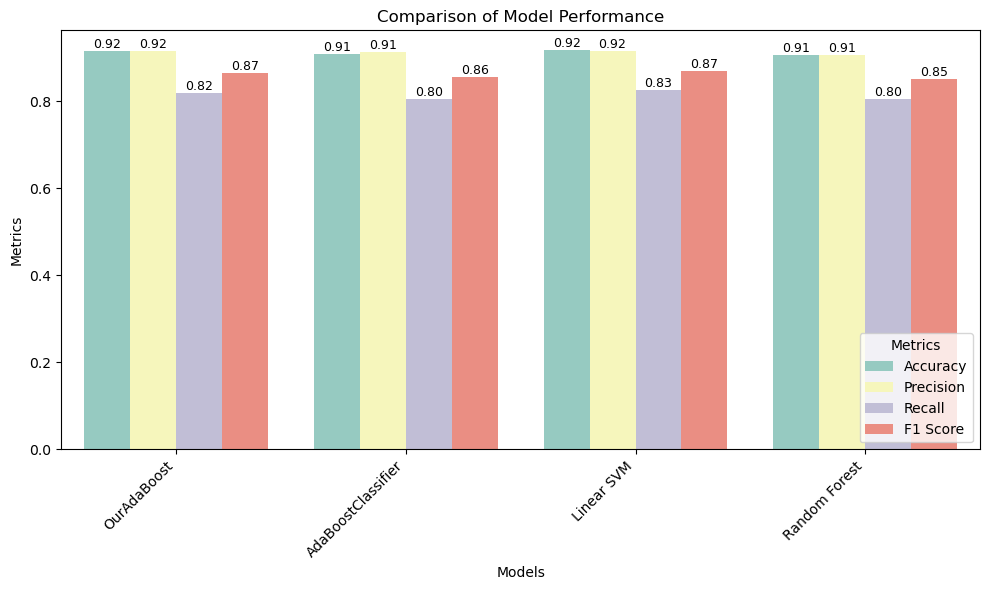

In [47]:
plot_model_comparison(models, metrics_dict)

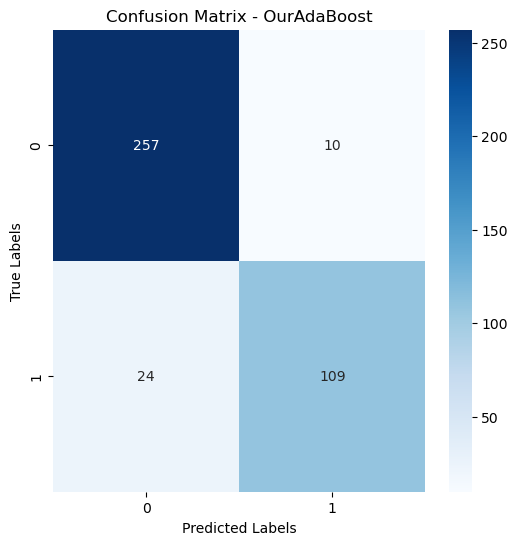

In [48]:
plot_confusion_matrix(y_test_2, y_preds[0], "OurAdaBoost")

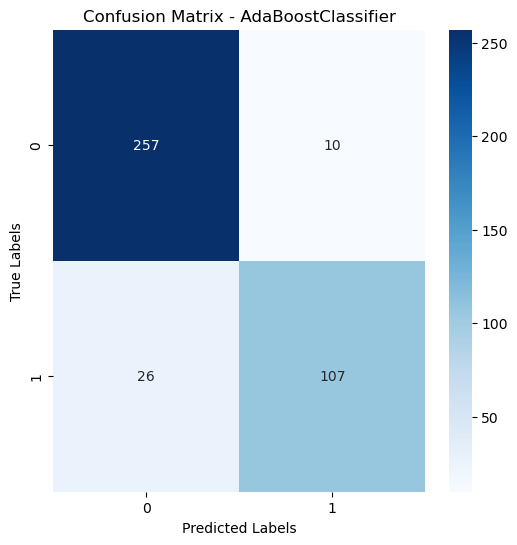

In [49]:
plot_confusion_matrix(y_test_2, y_preds[1], "AdaBoostClassifier")

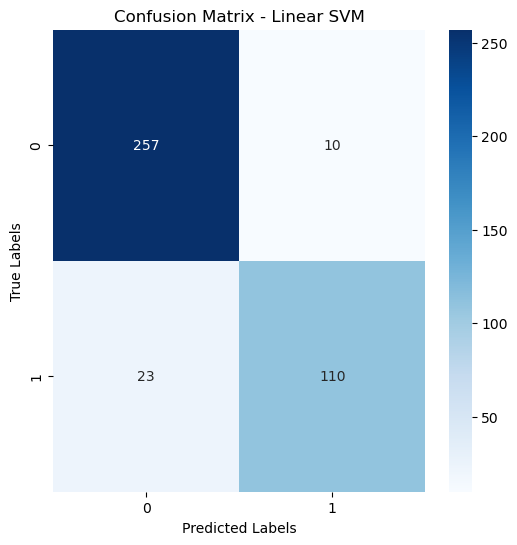

In [50]:
plot_confusion_matrix(y_test_2, y_preds[2], "Linear SVM")

In [51]:
plot_confusion_matrix(y_test_2, y_preds[3], "Random Forest")

Tree: Train accuracy=90.75%, Test accuracy=91.50%


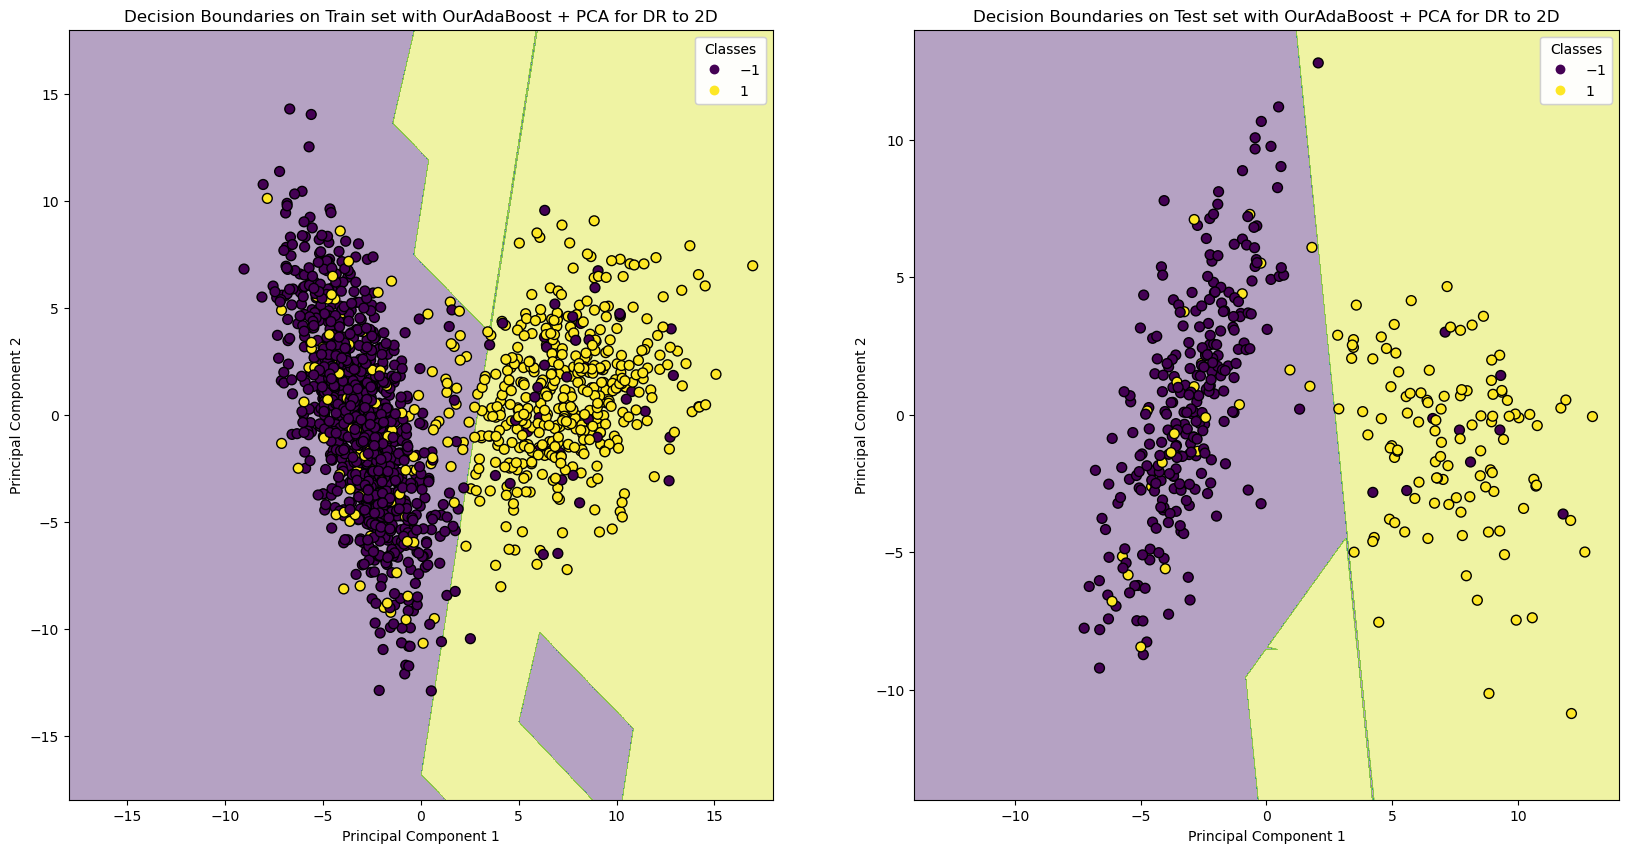

In [52]:
plot_decision_boundaries_comparison_with_dr(x_train_2, y_train_2, x_test_2, y_test_2, models[0], ['x1', 'x2'])

Tree: Train accuracy=90.88%, Test accuracy=91.00%


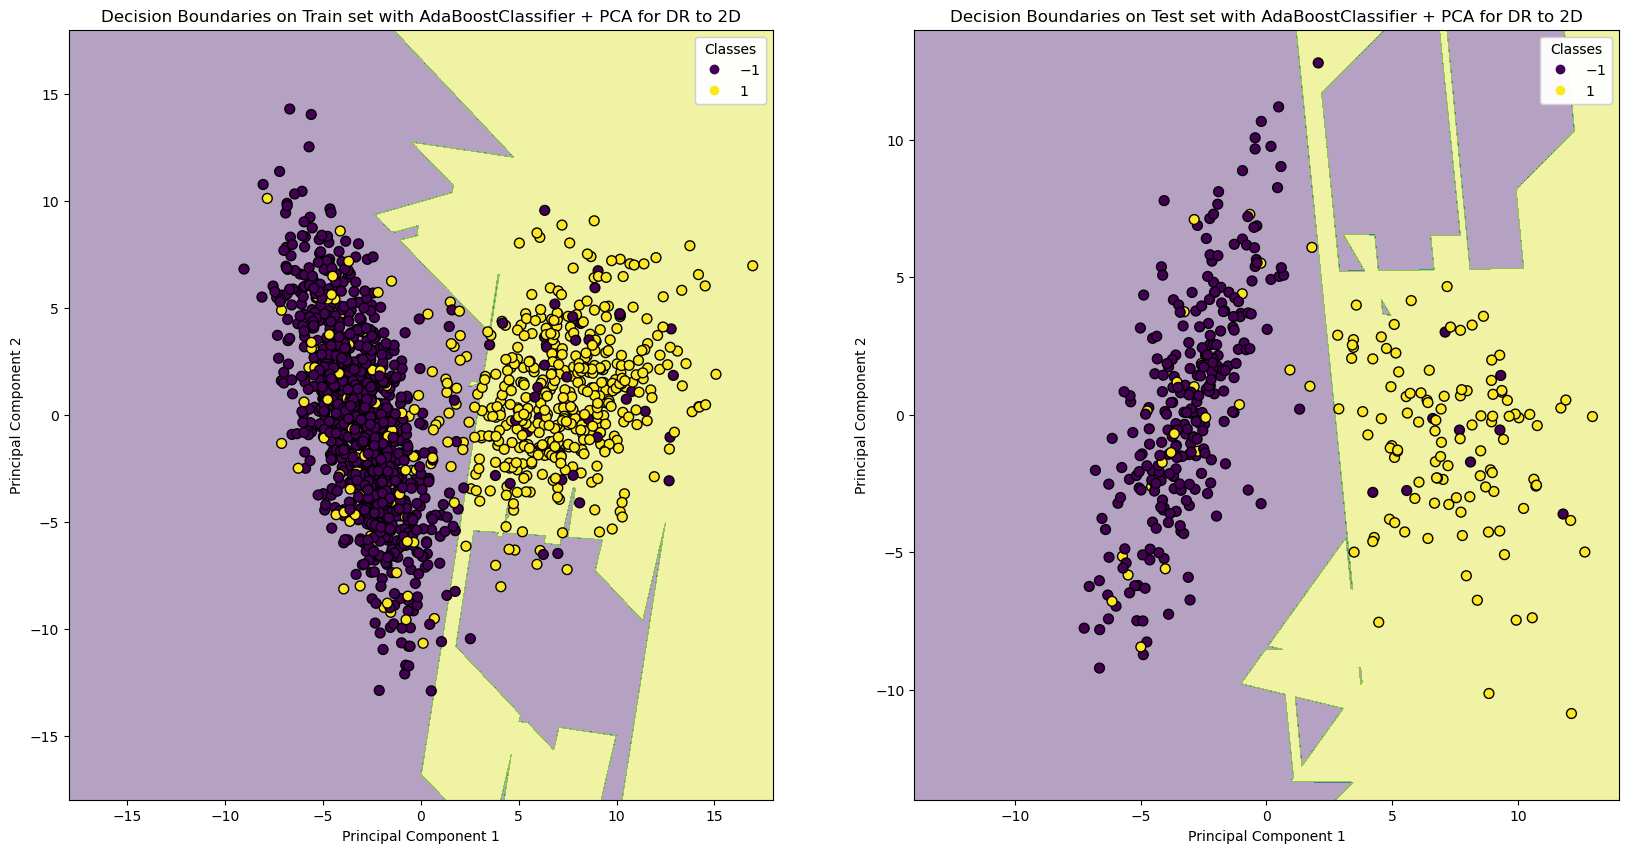

In [53]:
plot_decision_boundaries_comparison_with_dr(x_train_2, y_train_2, x_test_2, y_test_2, models[1], ['x1', 'x2'])

Tree: Train accuracy=91.06%, Test accuracy=91.75%


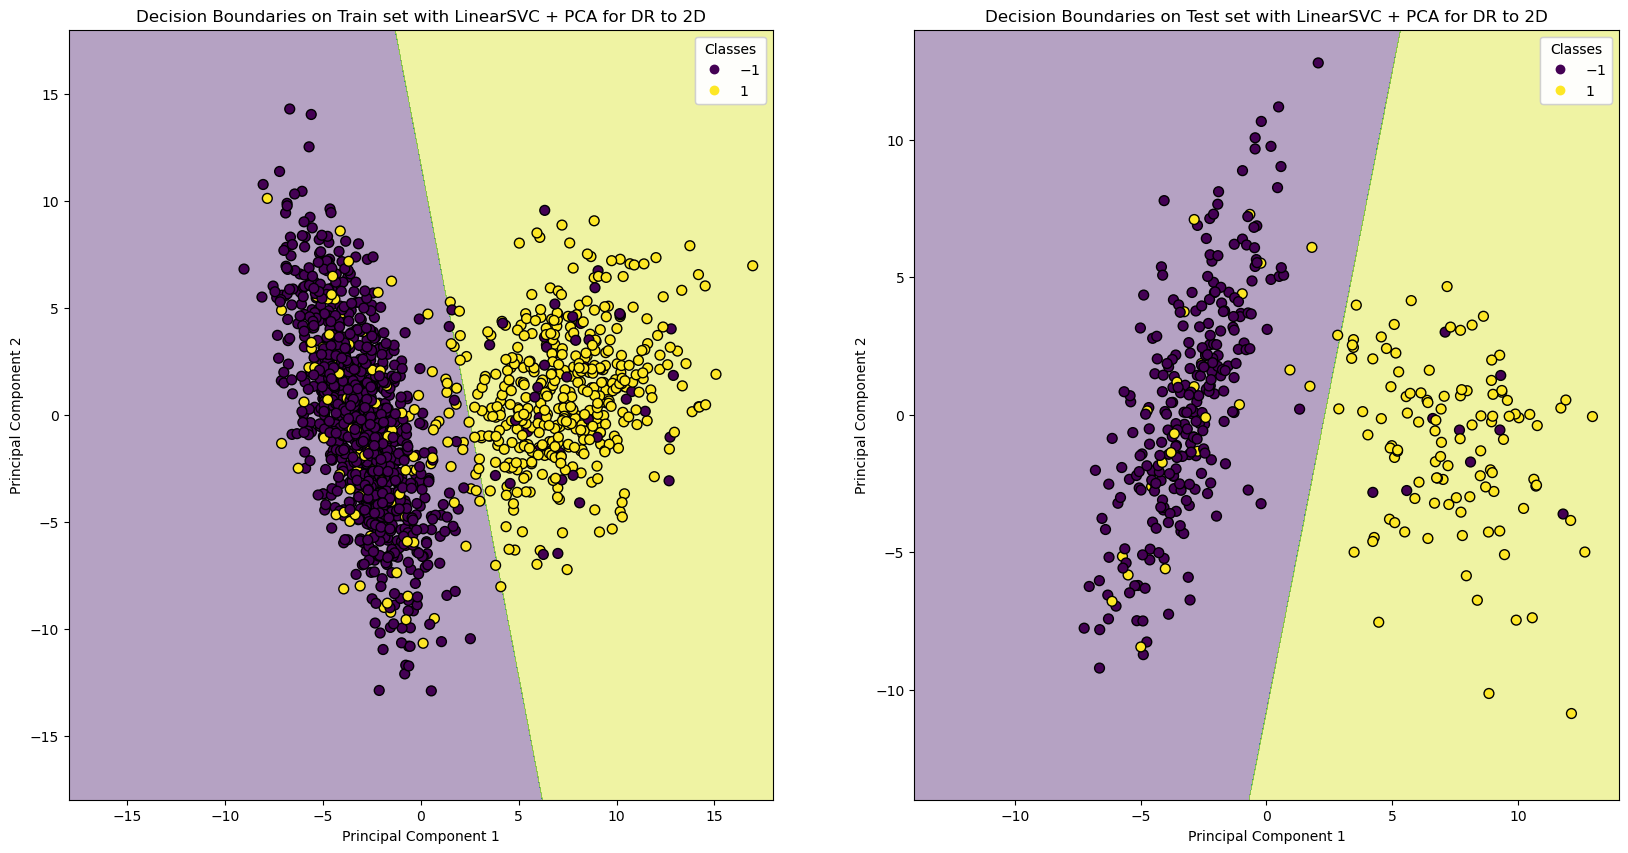

In [54]:
plot_decision_boundaries_comparison_with_dr(x_train_2, y_train_2, x_test_2, y_test_2, models[2], ['x1', 'x2'])

Tree: Train accuracy=100.00%, Test accuracy=90.75%


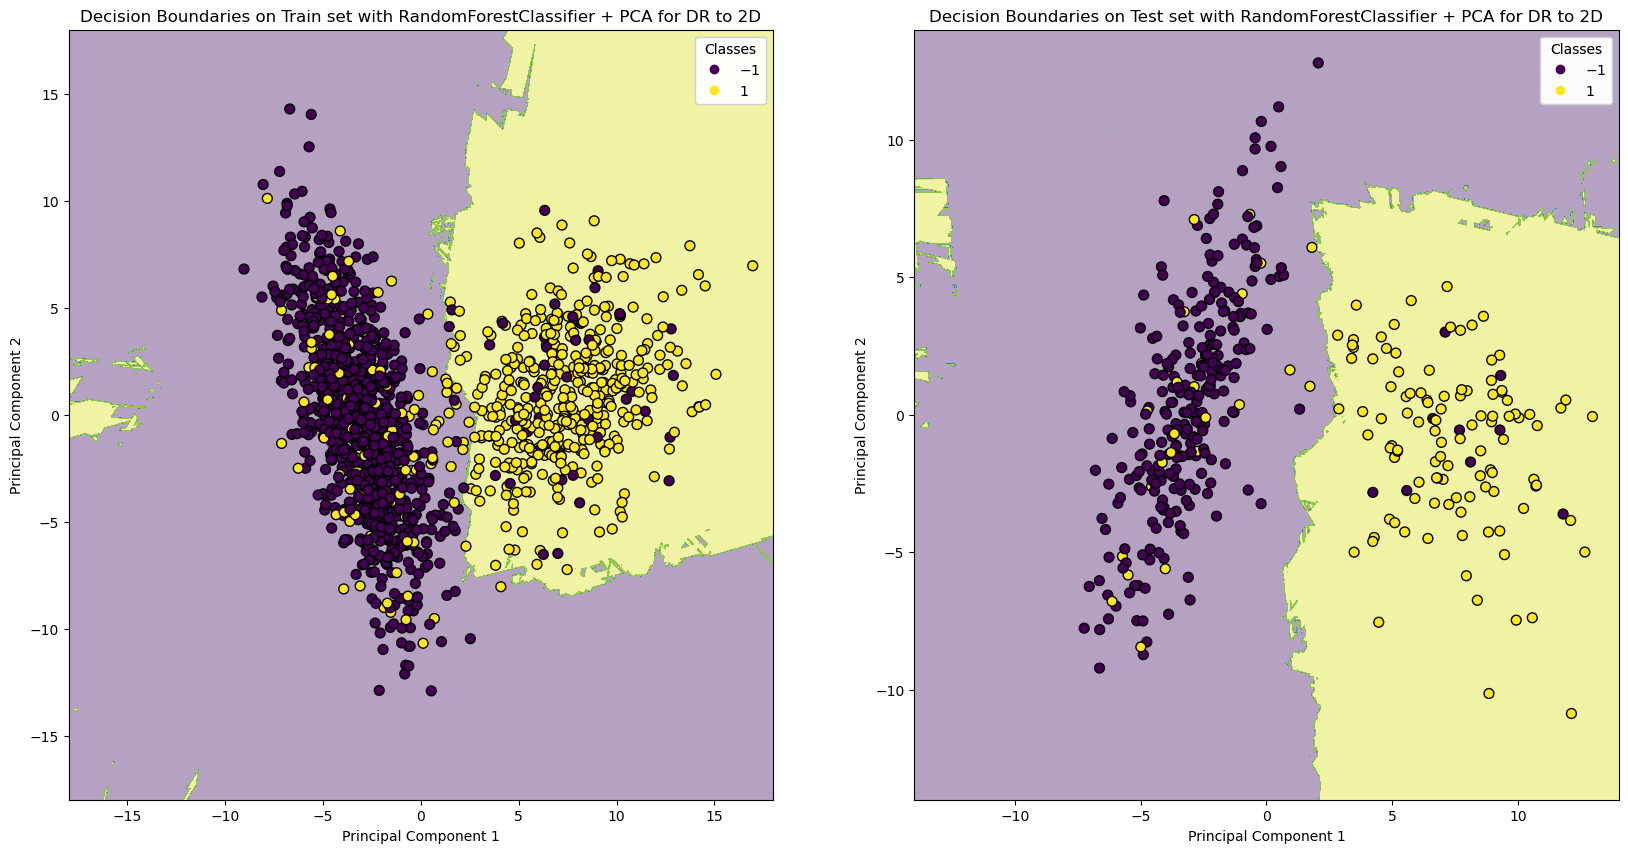

In [55]:
plot_decision_boundaries_comparison_with_dr(x_train_2, y_train_2, x_test_2, y_test_2, models[3], ['x1', 'x2'])